In [128]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random
import numpy as np

# diffusionlab imports (adjust imports if your environment differs)
from diffusionlab.dynamics import VariancePreservingProcess
from diffusionlab.losses import DiffusionLoss
from diffusionlab.vector_fields import VectorFieldType

# repo imports
from src.diffusion_mem_gen.models.gmm import (
    IsoHomGMMInitStrategy,
    iso_hom_gmm_create_initialization_parameters,
    IsoHomGMMSharedParametersEstimator,
)
from src.diffusion_mem_gen.utils.factories import compute_loss_factory

key = random.PRNGKey(0)

## Here we investigate empirically how the new loss term behaves

We first investigate the noise schedule: $\lambda(t)$

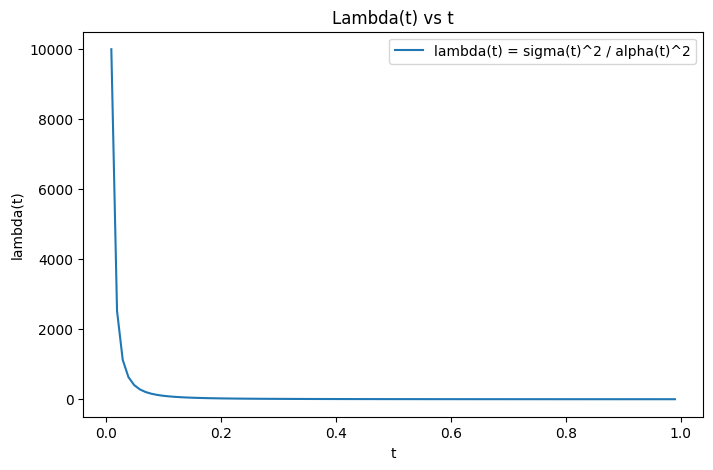

In [129]:
VP = VariancePreservingProcess()

t_steps = 100
t_schedule = jnp.linspace(0.01, 0.99, t_steps)

# VP.sigma_prime and VP.alpha_prime expect scalar input; use vmap for vectorization
sigma_prime_fn = jax.vmap(VP.sigma)
alpha_prime_fn = jax.vmap(VP.alpha)

sigma_prime_vals = sigma_prime_fn(t_schedule)
alpha_prime_vals = alpha_prime_fn(t_schedule)
lambda_vals = alpha_prime_vals**2 / sigma_prime_vals**2 

plt.figure(figsize=(8,5))
plt.plot(t_schedule, lambda_vals, label="lambda(t) = sigma(t)^2 / alpha(t)^2")
plt.xlabel('t')
plt.ylabel('lambda(t)')
plt.title("Lambda(t) vs t")
plt.legend()
plt.show()

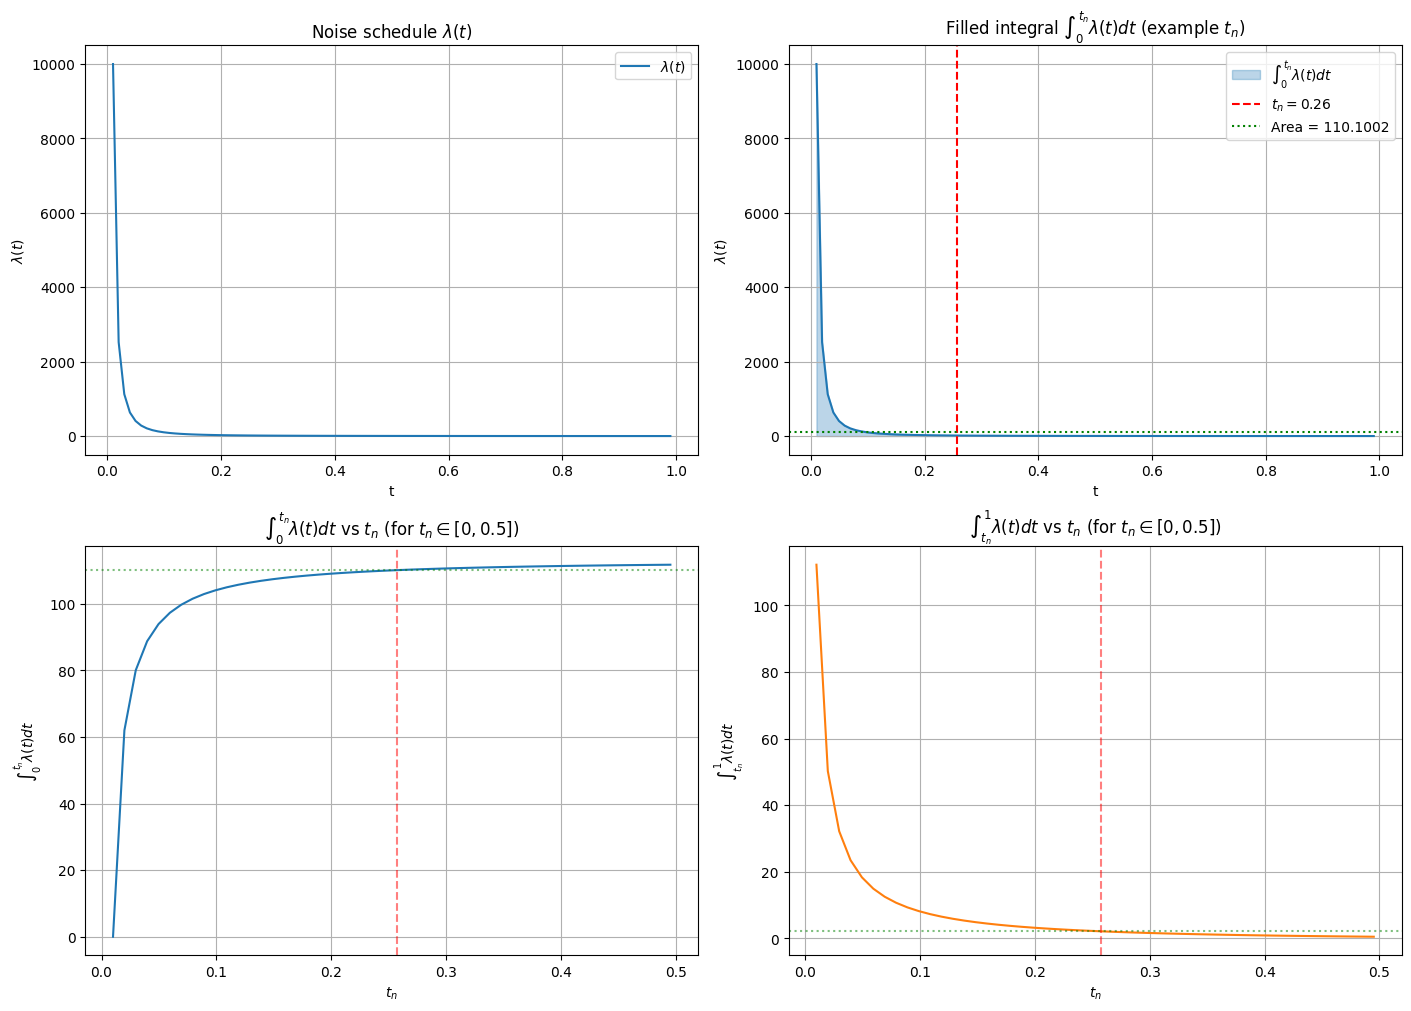

Example: Integral of lambda(t) from 0 to t_n (0.26): 110.1002
Example: Integral of lambda(t) from t_n (0.26) to 1: 2.1422


In [130]:
# Plot integrals and their dependence on t_n, all on one figure for t_n in [0, 0.5]

# Define t_n values in [0, 0.5]
halfway = 0.5
tn_mask = t_schedule <= halfway
t_n_vals = t_schedule[tn_mask]

# Precompute integrals for the masked t_n values
integral_0_to_tn_vals = []
integral_tn_to_1_vals = []

for idx, t_n in enumerate(t_n_vals):
    integral_0_to_tn = np.trapezoid(np.array(lambda_vals[:idx+1]), np.array(t_schedule[:idx+1]))
    integral_tn_to_1 = np.trapezoid(np.array(lambda_vals[idx:]), np.array(t_schedule[idx:]))
    integral_0_to_tn_vals.append(integral_0_to_tn)
    integral_tn_to_1_vals.append(integral_tn_to_1)

# For reference, select the central t_n for filled region illustration
t_n_idx = len(t_n_vals) // 2
t_n = float(t_n_vals[t_n_idx])
integral_lambda_0_tn = integral_0_to_tn_vals[t_n_idx]
integral_lambda_tn_1 = integral_tn_to_1_vals[t_n_idx]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# Top left: lambda(t) curve
axes[0, 0].plot(t_schedule, lambda_vals, color="C0", label=r"$\lambda(t)$")
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel(r'$\lambda(t)$')
axes[0, 0].set_title(r"Noise schedule $\lambda(t)$")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Top right: Integral from 0 to t_n (filled area) for a single t_n
axes[0, 1].plot(t_schedule, lambda_vals, color="C0")
axes[0, 1].fill_between(t_schedule[:t_n_idx+1], lambda_vals[:t_n_idx+1], alpha=0.3, color='C0', label=r"$\int_0^{t_n} \lambda(t)dt$")
axes[0, 1].axvline(x=t_n, color='r', linestyle='--', label=fr'$t_n = {t_n:.2f}$')
axes[0, 1].axhline(y=integral_lambda_0_tn, color='g', linestyle=':', label=fr'Area = {integral_lambda_0_tn:.4f}')
axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel(r'$\lambda(t)$')
axes[0, 1].set_title(r"Filled integral $\int_0^{t_n} \lambda(t)dt$ (example $t_n$)")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Bottom left: how the integral from 0 to t_n varies as t_n changes on [0,0.5]
axes[1, 0].plot(t_n_vals, integral_0_to_tn_vals, color='C0')
axes[1, 0].set_xlabel(r'$t_n$')
axes[1, 0].set_ylabel(r'$\int_0^{t_n} \lambda(t)dt$')
axes[1, 0].set_title(r'$\int_0^{t_n} \lambda(t)dt$ vs $t_n$ (for $t_n\in[0,0.5]$)')
axes[1, 0].grid(True)
axes[1, 0].axvline(x=t_n, color='r', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=integral_lambda_0_tn, color='g', linestyle=':', alpha=0.5)

# Bottom right: how the integral from t_n to 1 varies as t_n changes on [0,0.5]
axes[1, 1].plot(t_n_vals, integral_tn_to_1_vals, color='C1')
axes[1, 1].set_xlabel(r'$t_n$')
axes[1, 1].set_ylabel(r'$\int_{t_n}^1 \lambda(t)dt$')
axes[1, 1].set_title(r'$\int_{t_n}^1 \lambda(t)dt$ vs $t_n$ (for $t_n\in[0,0.5]$)')
axes[1, 1].grid(True)
axes[1, 1].axvline(x=t_n, color='r', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=integral_lambda_tn_1, color='g', linestyle=':', alpha=0.5)

plt.show()

print(f"Example: Integral of lambda(t) from 0 to t_n ({t_n:.2f}): {integral_lambda_0_tn:.4f}")
print(f"Example: Integral of lambda(t) from t_n ({t_n:.2f}) to 1: {integral_lambda_tn_1:.4f}")

## Crafting model environment

In [215]:
# Dimension and training samples.
laboratory_d = 30 # data dimension
laboratory_N = 100 # number of training samples, must be pollynomial in d
laboratory_K = 12 # number of components in the GMM

laboratory_M = 80 # The capacity of the models, we investiage for less M < N

#u_means_mean = 20 # order d
u_means_variance = 30 ** (1/2) # order 1, controls the variance of the means of the true distributon 
sample_variance = 1  # isotropic variance for each component

# Time grid for evaluation
times = jnp.linspace(0.01, 0.99, 26)

In [216]:
# Ground-truth GMM params (you can replace these with your exact true mixture)
key, sk = random.split(key)
true_means = random.normal(sk, (laboratory_K, laboratory_d)) * u_means_variance
equal_weighted_prior = jnp.array([1/laboratory_K for _ in range(laboratory_K)])  # must sum to 1

# Sample training set from the true GMM
key, sk = random.split(key)
comp_ids = random.choice(sk, laboratory_K, shape=(laboratory_N,), p=equal_weighted_prior)
key, sk = random.split(key)
X_train = true_means[comp_ids] + jnp.sqrt(sample_variance) * random.normal(sk, (laboratory_N, laboratory_d))

### Defining the Diffusion Process, and the diffusin loss_obj  

In [217]:
# Diffusion process
diffusion_process = VariancePreservingProcess()

# Loss object: replace with your custom loss instance if you have one
loss_obj = DiffusionLoss(diffusion_process, vector_field_type=VectorFieldType.EPS, num_noise_draws_per_sample=100)

### Build PMEM denoiser (uses training points as memorised means)

In [218]:
key, sk = random.split(key)

context = {
    "X_train": X_train,
    "init_var_scale": 1e-6,
    "init_means_noise_var": 0.0, # Not exactly sure what this is
}
means_pmem, var_pmem, priors_pmem = iso_hom_gmm_create_initialization_parameters(
    sk, IsoHomGMMInitStrategy.PMEM, laboratory_d, laboratory_M, context
)

pmem_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_M,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=means_pmem,
    init_var=var_pmem,
    priors=priors_pmem,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_24548\1608411457.py:12: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  pmem_model = IsoHomGMMSharedParametersEstimator(


### Build MEM denoiser (uses training points as memorised means)


In [219]:
key, sk = random.split(key)

means_mem, var_mem, priors_mem = iso_hom_gmm_create_initialization_parameters(
    sk, IsoHomGMMInitStrategy.PMEM, laboratory_d, laboratory_N, context
)

mem_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_N,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=means_mem,
    init_var=var_mem,
    priors=priors_mem,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_24548\4216725792.py:7: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  mem_model = IsoHomGMMSharedParametersEstimator(


### Build Generalising denoiser

In [220]:
generalising_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_K,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=true_means,
    init_var=jnp.asarray(sample_variance),
    priors=equal_weighted_prior,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_24548\2340100790.py:1: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  generalising_model = IsoHomGMMSharedParametersEstimator(


### Testing ambient diffusion loss

In [221]:
from investigating_diffusion_loss import AmbientDiffusionLoss

t_n_value = jnp.array(0.1)
t_val = jnp.array(0.15)

In [222]:
ambient_loss_obj = AmbientDiffusionLoss(diffusion_process, num_noise_draws_per_sample=1, t_n=t_n_value)

Verifed that it runs for all models.

In [223]:
key, subk = random.split(key)

assert t_val > t_n_value
compute_loss = compute_loss_factory(ambient_loss_obj, jnp.array(t_val)) # This prepares a function on the sum of the loss over the batch.
loss_val = compute_loss(subk, mem_model, X_train) / X_train.shape[0]          # This calculates the average of the loss over the batch.
print(loss_val)

0.0008085102


Verified that Ambient loss function is working.

In [224]:
key, subk = random.split(key)
X_t_n_eps = jax.random.normal(subk, X_train.shape)

batch_diffusion_forward = jax.vmap(
            diffusion_process.forward, in_axes=(0, None, 0)
        )
X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value, X_t_n_eps)

print(f"X_train mean: {jnp.mean(X_train):.4f}, std: {jnp.std(X_train):.4f}")
print(f"X_t_n_dataset mean: {jnp.mean(X_t_n_dataset):.4f}, std: {jnp.std(X_t_n_dataset):.4f}")

X_train mean: -0.4622, std: 5.3446
X_t_n_dataset mean: -0.4592, std: 5.3189


In [225]:
loss_val_mem = compute_loss(subk, mem_model, X_t_n_dataset) / X_train.shape[0]  
loss_val_pmem = compute_loss(subk, pmem_model, X_t_n_dataset) / X_train.shape[0]  
loss_val_generalising = compute_loss(subk, generalising_model, X_t_n_dataset) / X_train.shape[0]  

print(f"loss_val_mem: {loss_val_mem:.6e}, loss_val_pmem: {loss_val_pmem:.6e}, loss_val_generalising: {loss_val_generalising:.6e}")

loss_val_mem: 1.708426e-03, loss_val_pmem: 2.932682e-02, loss_val_generalising: 3.635752e-03


## Writing the Loss Objective

In [226]:
def L_N(model_callable, lambda_fn, t_val_array, t_n_value, X_0_dataset, X_t_n_dataset):
    '''
    This function computes the L_N loss for a given model and a given lambda function.
    '''

    ambient_loss_obj = AmbientDiffusionLoss(diffusion_process, num_noise_draws_per_sample=1, t_n=t_n_value)
    standard_loss_obj = DiffusionLoss(diffusion_process, vector_field_type=VectorFieldType.X0, num_noise_draws_per_sample=1)

    def L_N_t_ambient(model_callable, t_n_value, t_val, X_t_n_dataset):
        '''
        This function computes the L_N_t for the ambient denoising term.
        '''
        assert t_val > t_n_value
        
        compute_loss = compute_loss_factory(ambient_loss_obj, jnp.array(t_val))
        loss_val = compute_loss(subk, model_callable, X_t_n_dataset) / X_train.shape[0] 
        
        return loss_val

    def L_N_t_standard_score(model_callable, t_val, X_t_dataset):
        '''
        This function computes the L_N_t for the standard denoising term.
        '''
        compute_loss = compute_loss_factory(standard_loss_obj, jnp.array(t_val))
        loss_val = compute_loss(subk, model_callable, X_t_dataset) / X_train.shape[0] 
        
        return loss_val
    
    # Split into less than t_n and greater than t_n
    less_than_n_mask = jnp.less_equal(t_val_array, t_n_value)
    greater_than_n_mask = jnp.logical_not(less_than_n_mask)

    standard_denoising_t_values = t_val_array[less_than_n_mask]
    ambient_denoising_t_values = t_val_array[greater_than_n_mask]
  
    # Compute the loss for the standard denoising term
    standard_denoising_loss_values = []
    for t in standard_denoising_t_values:
        loss_val = L_N_t_standard_score(model_callable, t, X_0_dataset)
        standard_denoising_loss_values.append(lambda_fn(t) * loss_val)

    averaged_standard_denoising_loss = np.mean(standard_denoising_loss_values)

    # Compute the loss for the ambient denoising term
    ambient_denoising_loss_values = []
    for t in ambient_denoising_t_values:
        loss_val = L_N_t_ambient(model_callable, t_n_value, t, X_t_n_dataset)
        ambient_denoising_loss_values.append(lambda_fn(t) * loss_val)
    
    averaged_ambient_denoising_loss = np.mean(ambient_denoising_loss_values)

    return averaged_standard_denoising_loss + averaged_ambient_denoising_loss, standard_denoising_loss_values, ambient_denoising_loss_values


In [227]:
lambda_fn = lambda t: t
    

t_val_array = jnp.linspace(0.01, 0.99, 26)
t_n_value = jnp.array(0.5)

key, subk = random.split(key)
X_t_n_eps = jax.random.normal(subk, X_train.shape)

batch_diffusion_forward = jax.vmap(
            diffusion_process.forward, in_axes=(0, None, 0)
        )
X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value, X_t_n_eps)

In [228]:
pmem_results = L_N(pmem_model, lambda_fn, t_val_array, t_n_value, X_train, X_t_n_dataset)
mem_results = L_N(mem_model, lambda_fn, t_val_array, t_n_value, X_train, X_t_n_dataset)
generalising_results = L_N(generalising_model, lambda_fn, t_val_array, t_n_value, X_train, X_t_n_dataset)

In [229]:
print(pmem_results)
print(mem_results)
print(generalising_results)

(np.float32(0.12982863), [Array(0.00086305, dtype=float32), Array(0.00432794, dtype=float32), Array(0.00778064, dtype=float32), Array(0.01116096, dtype=float32), Array(0.01478256, dtype=float32), Array(0.01825709, dtype=float32), Array(0.0217315, dtype=float32), Array(0.02516313, dtype=float32), Array(0.02799485, dtype=float32), Array(0.03228992, dtype=float32), Array(0.03577568, dtype=float32), Array(0.03876682, dtype=float32), Array(0.04233513, dtype=float32)], [Array(0.00432845, dtype=float32), Array(0.01416533, dtype=float32), Array(0.02495042, dtype=float32), Array(0.03631195, dtype=float32), Array(0.04786475, dtype=float32), Array(0.0594774, dtype=float32), Array(0.07116084, dtype=float32), Array(0.08291715, dtype=float32), Array(0.0957579, dtype=float32), Array(0.11155577, dtype=float32), Array(0.14087258, dtype=float32), Array(0.18971226, dtype=float32), Array(0.5274682, dtype=float32)])
(np.float32(0.0872387), [Array(3.0430942e-11, dtype=float32), Array(6.292588e-12, dtype=flo

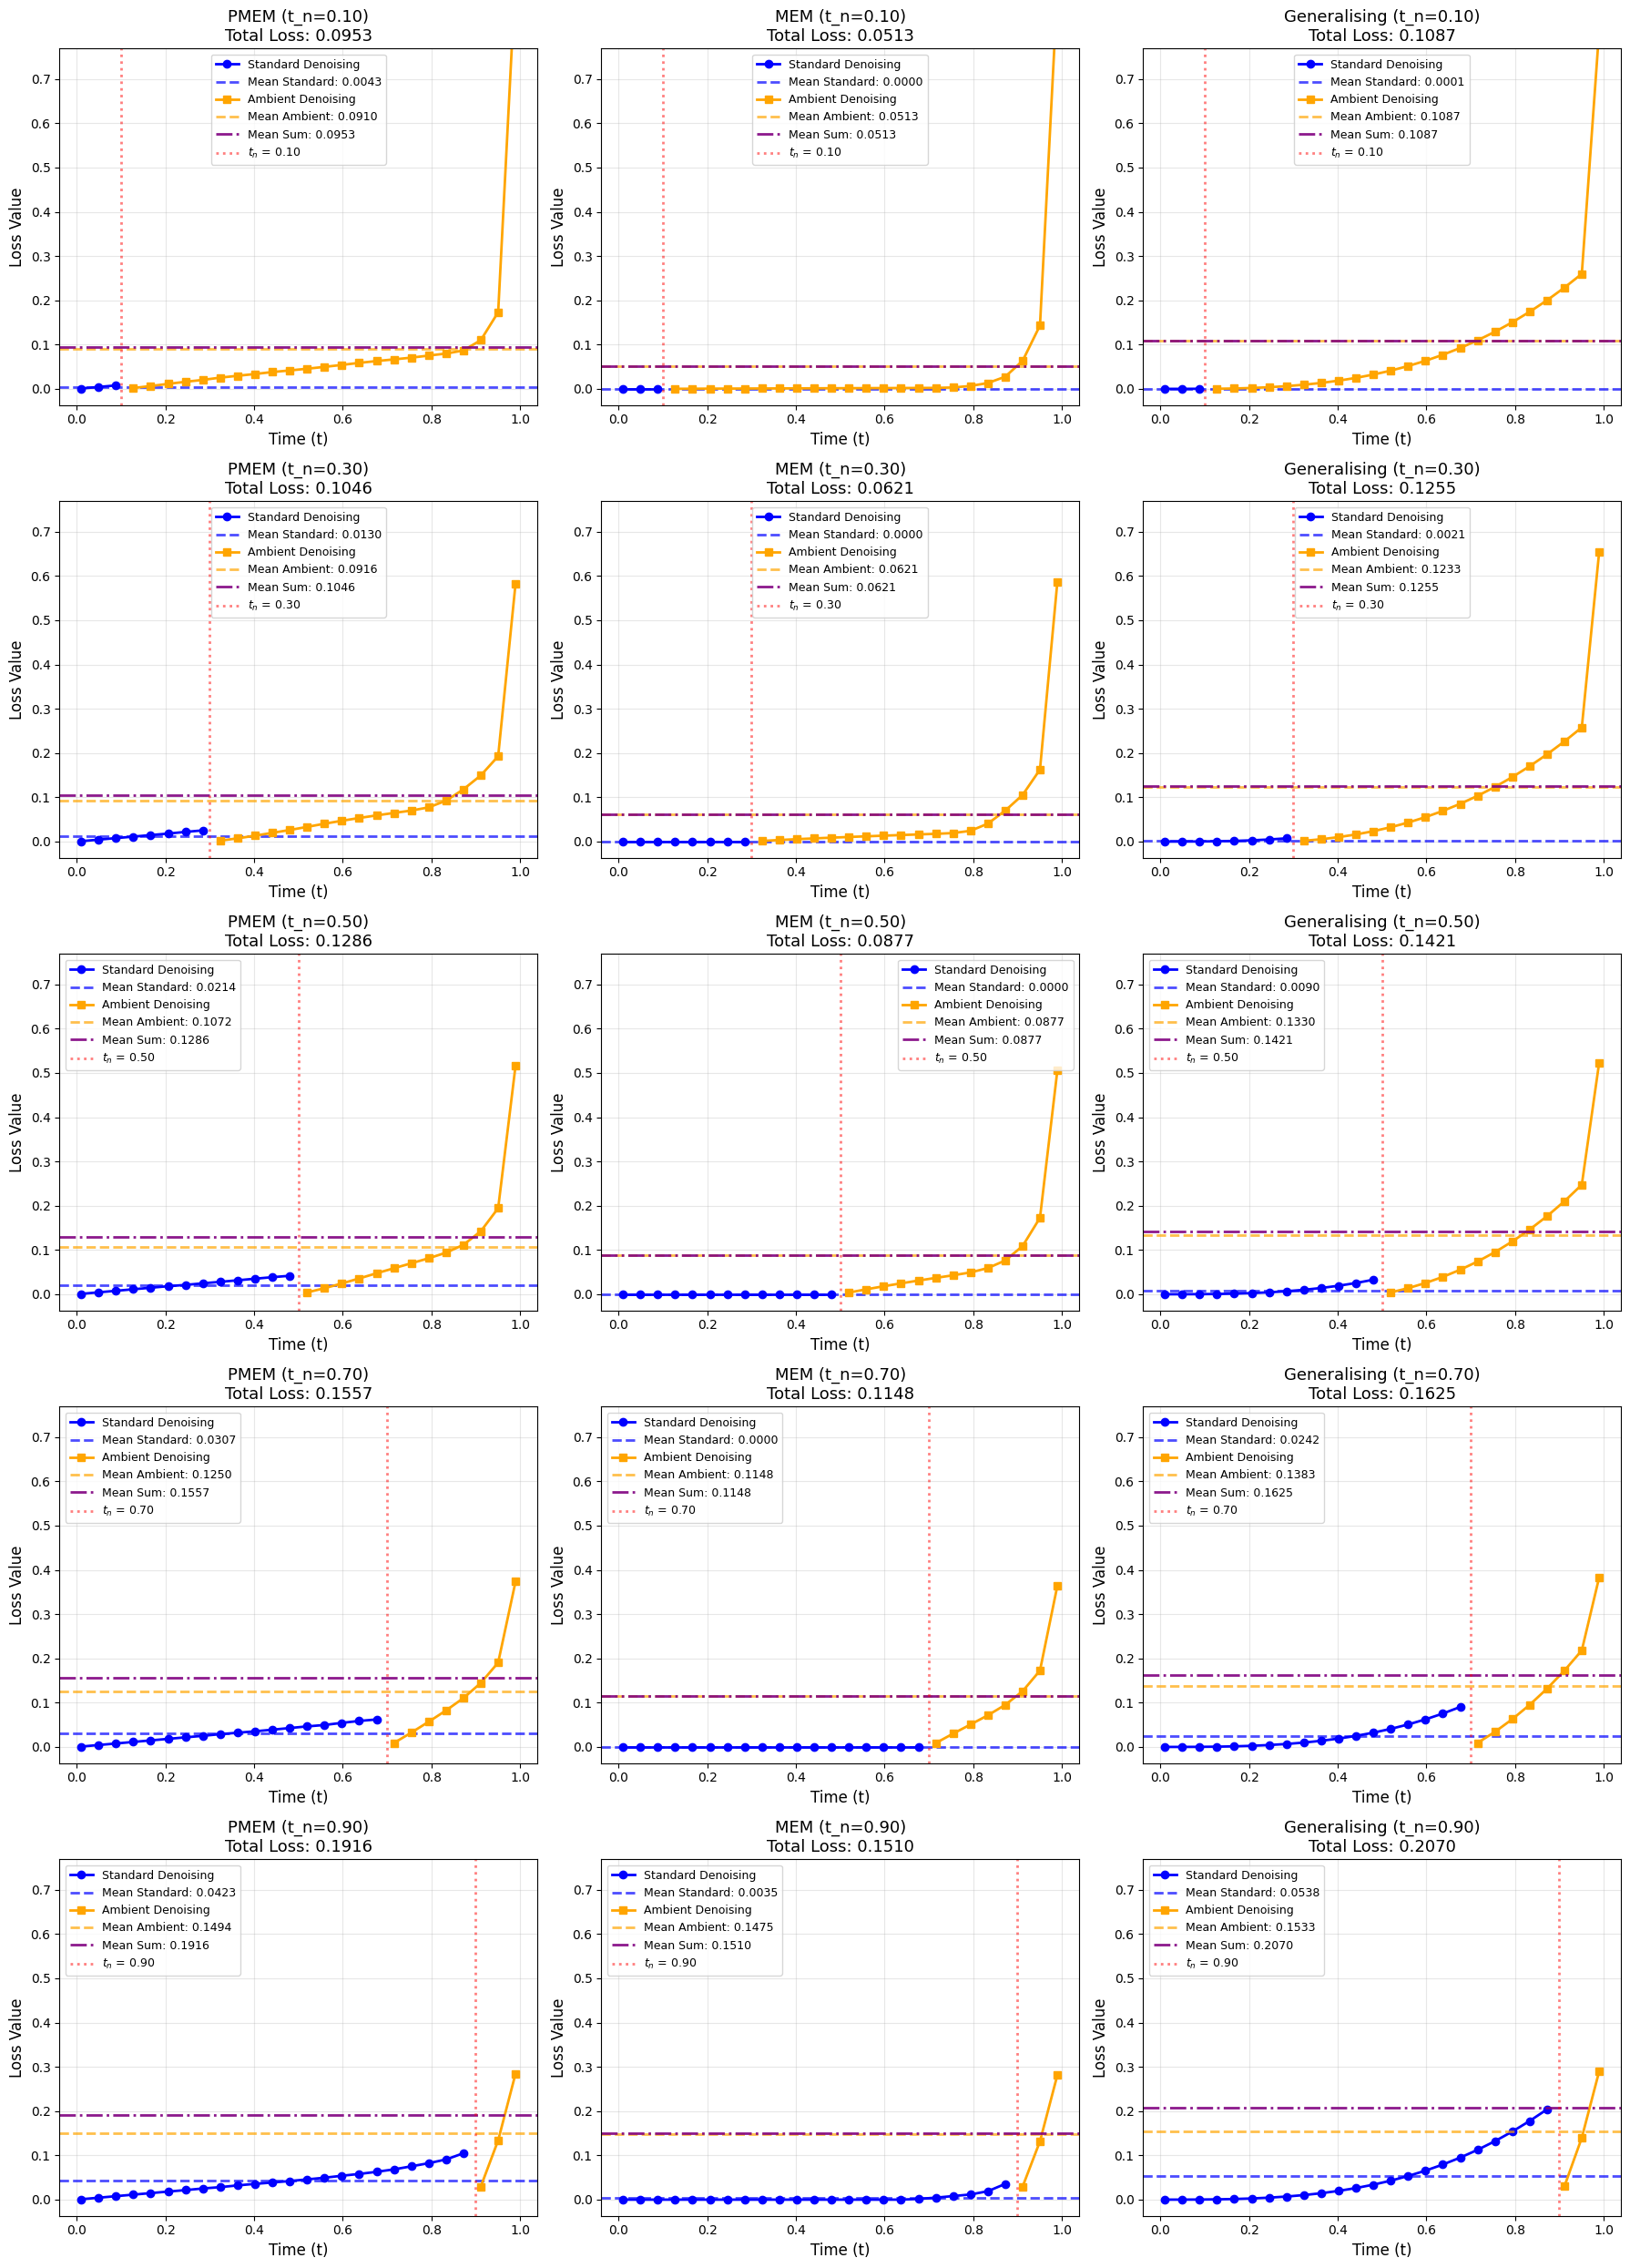

In [230]:
# For each t_n_value in the array, generate the plot as before
t_n_values = np.linspace(0.1, 0.9, 5)  # 5 values between 0 and 0.9

t_val_array = jnp.linspace(0.01, 0.99, 26)

models = ['PMEM', 'MEM', 'Generalising']
model_objs = [pmem_model, mem_model, generalising_model]

# We'll plot each t_n_value in a row; 
# Each row will have 3 columns (one per model), for a grid of len(t_n_values) x 3.

# ----------- Determine global y-limits for all losses -----------
all_losses = []

for t_n_value in t_n_values:
    t_n_value_jax = jnp.array(t_n_value)
    key, subk = random.split(key)
    X_t_n_eps = jax.random.normal(subk, X_train.shape)
    batch_diffusion_forward = jax.vmap(
            diffusion_process.forward, in_axes=(0, None, 0)
        )
    X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value_jax, X_t_n_eps)
    results = [
        L_N(model_obj, lambda_fn, t_val_array, t_n_value_jax, X_train, X_t_n_dataset)
        for model_obj in model_objs
    ]
    for result in results:
        _, standard_denoising_loss_values, ambient_denoising_loss_values = result
        all_losses.extend(np.array(standard_denoising_loss_values).flatten())
        all_losses.extend(np.array(ambient_denoising_loss_values).flatten())

# Compute global min and max for y-axis, with some padding
all_losses = np.array(all_losses)
ymin = np.min(all_losses)
ymax = np.max(all_losses)
ypad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
ymin = ymin - ypad
ymax = ymax + ypad

# -------------- Now do the main plotting --------------
fig, axes = plt.subplots(len(t_n_values), 3, figsize=(18, 5 * len(t_n_values)), squeeze=False)  

for row_idx, t_n_value in enumerate(t_n_values):
    t_n_value_jax = jnp.array(t_n_value)
    key, subk = random.split(key)
    X_t_n_eps = jax.random.normal(subk, X_train.shape)
    batch_diffusion_forward = jax.vmap(
            diffusion_process.forward, in_axes=(0, None, 0)
        )
    X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value_jax, X_t_n_eps)
    results = [
        L_N(model_obj, lambda_fn, t_val_array, t_n_value_jax, X_train, X_t_n_dataset)
        for model_obj in model_objs
    ]
    for col_idx, (ax, model_name, result) in enumerate(zip(axes[row_idx], models, results)):
        total_loss, standard_denoising_loss_values, ambient_denoising_loss_values = result
        
        # Get the t values for each section
        less_than_n_mask = jnp.less_equal(t_val_array, t_n_value)
        standard_denoising_t_values = t_val_array[less_than_n_mask]
        ambient_denoising_t_values = t_val_array[jnp.logical_not(less_than_n_mask)]
        
        # Convert to numpy for plotting
        standard_t_np = np.array(standard_denoising_t_values)
        ambient_t_np = np.array(ambient_denoising_t_values)
        standard_loss_np = np.array(standard_denoising_loss_values)
        ambient_loss_np = np.array(ambient_denoising_loss_values)
        
        # Calculate means
        mean_standard = np.mean(standard_loss_np)
        mean_ambient = np.mean(ambient_loss_np)
        mean_sum = mean_standard + mean_ambient  # Add the requested line: the averages summed
        
        # Plot standard denoising losses
        if len(standard_t_np) > 0:
            ax.plot(standard_t_np, standard_loss_np, 'o-', label='Standard Denoising', 
                    linewidth=2, markersize=6, color='blue')
            ax.axhline(y=mean_standard, color='blue', linestyle='--', 
                      linewidth=2, alpha=0.7, label=f'Mean Standard: {mean_standard:.4f}')
        
        # Plot ambient denoising losses
        if len(ambient_t_np) > 0:
            ax.plot(ambient_t_np, ambient_loss_np, 's-', label='Ambient Denoising', 
                    linewidth=2, markersize=6, color='orange')
            ax.axhline(y=mean_ambient, color='orange', linestyle='--', 
                      linewidth=2, alpha=0.7, label=f'Mean Ambient: {mean_ambient:.4f}')
        
        # Plot horizontal line for the sum of means
        ax.axhline(y=mean_sum, color='purple', linestyle='-.', linewidth=2, alpha=0.9, label=f"Mean Sum: {mean_sum:.4f}")

        # Add vertical line at t_n
        ax.axvline(x=float(t_n_value), color='red', linestyle=':', 
                  linewidth=2, alpha=0.5, label=f'$t_n$ = {float(t_n_value):.2f}')
        
        ax.set_xlabel('Time (t)', fontsize=12)
        ax.set_ylabel('Loss Value', fontsize=12)
        ax.set_title(f'{model_name} (t_n={float(t_n_value):.2f})\nTotal Loss: {float(total_loss):.4f}', fontsize=13)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        
        # Set the global y-limits for this row
        ax.set_ylim([ymin, ymax])

plt.tight_layout()
plt.show()